# Bagmati catchment
# Hyperparameter tuning using model_builder function from tensorflow (MinMax normalization)
(After midterm)
#(https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [346]:
import numpy as np
import pandas as pd

### define file path
path = 'Non_scaled_6_input_Bagmati_yr.csv'  ####### This excel data is not scaled/normalized
## Read CSV file and convert it to dataframe
df = pd.read_csv( path, sep = ',', header = 'infer')


In [347]:
df

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.878,25.060,3.613,8.190,1.608,28.160,299.0
1,0.000,0.878,25.060,3.613,8.190,1.608,182.0
2,25.527,0.000,0.878,25.060,3.613,8.190,151.0
3,36.896,25.527,0.000,0.878,25.060,3.613,561.0
4,6.184,36.896,25.527,0.000,0.878,25.060,384.0
...,...,...,...,...,...,...,...
2909,7.115,0.422,7.130,13.781,4.314,18.381,132.0
2910,3.118,7.115,0.422,7.130,13.781,4.314,107.0
2911,61.877,3.118,7.115,0.422,7.130,13.781,538.0
2912,112.900,61.877,3.118,7.115,0.422,7.130,921.0


In [348]:
df.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000
mean,5.433136,5.434821,5.397316,5.378893,5.378374,5.385596,149.648264
std,14.030448,14.032511,13.890520,13.851130,13.851243,13.857633,271.208820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.700000
75%,4.916000,4.916000,4.864500,4.864500,4.864500,4.864500,195.975000
max,364.590000,364.590000,364.590000,364.590000,364.590000,364.590000,5030.000000


# 1. Data splitting

##  Train, Validation and Test data 
###  70% train (2040 data points)
###  15% train (436 data points)
###  15% train (436 data points)

In [349]:
df_train = df.iloc[:2040]

df_val = df.iloc[2040:2476] 

df_test = df.iloc[2476:2912] 

# 2. Normalization

In [350]:
import pandas as pd
import numpy as np

### General function for all the normalization methods

def normalize_df(data, norm_method):     

    ## Normalize data using specified method
 
    if norm_method == 'minmax':
        # Min-Max normalization
        data = (data - data.min()) / (data.max() - data.min())
    elif norm_method == 'zscore':
        # Z-score normalization
        mean = data.mean()
        std = data.std()
        data = (data - mean) / std
    elif norm_method == 'max':
        # Max normalization
        data = 1 - ((data.max() - data)/data.max())
    else:
        raise ValueError("Invalid normalization method. Choose from: 'minmax', 'zscore', 'max'")
    return data



### MinMax normalization  (Date sets for training, validation and testing are nromalized separately)

In [351]:
## Z_score(standard)
df_train_norm = normalize_df(df_train, 'minmax')
df_val_norm = normalize_df(df_val, 'minmax')
df_test_norm = normalize_df(df_test, 'minmax')

In [352]:
###example
df_train_norm.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000
mean,0.014712,0.014746,0.014750,0.014761,0.014763,0.014801,0.030008
std,0.040109,0.040126,0.040125,0.040124,0.040123,0.040146,0.056863
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002144
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007881
75%,0.012448,0.012472,0.012472,0.012535,0.012535,0.012670,0.041374
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [353]:
### convert the dataframes to numpy arrays

df_train_f = df_train_norm.to_numpy()

df_val_f = df_val_norm.to_numpy()

df_test_f = df_test_norm.to_numpy()

In [354]:
### Define input and output sequences (list of sub sequences)

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 1    #### 5 input sequences and 2 output sequences



### Split into input and target variables

In [355]:
#### Training data


X_train, y_train = split_sequences(df_train_f, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)

# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 6

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)


(2036, 5, 6) (2036, 1)
(2036, 5, 6)


In [356]:
#### validation data

X_val, y_val = split_sequences(df_val_f , n_steps_in, n_steps_out)


X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

### reshape

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

print(X_val.shape, y_val.shape)


(432, 5, 6) (432, 1)


In [357]:
#### Test data

X_test, y_test = split_sequences(df_test_f , n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape, y_test.shape)


(432, 5, 6) (432, 1)


In [358]:
#### model fitting
import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model

from tensorflow.keras import initializers

from tensorflow.keras import layers


## Hyperparameter tuning using KerasTuner

In [359]:

import keras_tuner as kt


from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.engine.hyperparameters import Choice,Float

### a. Define model (Using model_buider function)
### (https://www.tensorflow.org/tutorials/keras/keras_tuner)
## MLP

In [360]:

def model_buider(hp):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Flatten(input_shape = (n_steps_in, n_features)))   ### flattening is important when using this function
 ###1. Tune the number of units in the first Dense layer
     
    hp_units = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    
###2. Tune the activation function

    hp_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
    
###3. Tune the weight initialization
    hp_initializer=hp.Choice('weight_init', ['he_uniform', 'glorot_uniform', 'random_normal' , 'lecun_normal'])  ##
   
    ### Fix the seeds for reproducibility purposes   
        
    if hp_initializer == 'he_uniform':
        init = tf.keras.initializers.he_uniform(seed=1)
    elif hp_initializer == 'glorot_uniform':
        init = tf.keras.initializers.glorot_uniform(seed=1)
    elif hp_initializer == 'random_normal':
        init = tf.keras.initializers.RandomNormal(seed=1)
    else:
        init = tf.keras.initializers.lecun_normal(seed=1)
    
###4. Tune the number of layers

    for i in range(hp.Int("num_layers", 1, 3)):
        
        model.add(keras.layers.Dense(units = hp_units, activation = hp_activation, kernel_initializer = init))
        model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
    ### Output layer
   
    model.add(keras.layers.Dense(1, kernel_initializer = init))
    model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
###4. Tune the optimizer 

    hp_optimizer = hp.Choice("optimizer", ['Adam', 'SGD', 'RMSprop'])

    model.compile (
                    optimizer = hp_optimizer, ##(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))###
                  
                    loss='mean_squared_error',
                   
                    metrics=[tf.keras.metrics.MeanSquaredError()])
    
  
    return model

    
 

### b.  Instantiate the tuner and perform hypertuning

In [361]:
#### Hyperband tuner ( it is a class)

tuner = kt.Hyperband(model_buider,
                     
                     objective= 'mean_squared_error',  ### should be the same as the loss funtion used when compiling
                     
                     max_epochs = 10,
                     
                     factor=2,  
                     
                     seed = 10,
                     
                     directory='Exhaustive_Opt_norm',
                     
                     project_name='Test1_minmax')

INFO:tensorflow:Reloading Oracle from existing project Exhaustive_Opt_norm\Test1_minmax\oracle.json
INFO:tensorflow:Reloading Tuner from Exhaustive_Opt_norm\Test1_minmax\tuner0.json


In [362]:
from keras.callbacks import TensorBoard

import datetime, os

log_dir = "Exhaustive_Opt_MinMax/Test1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")   ### for the purpose of TensorBoard visualization


In [363]:
#tb = TensorBoard(log_dir=log_dir)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [364]:
### Create a callback to stop training early after reaching a certain value for the validation loss.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### C. Run hyperparameter search 

# 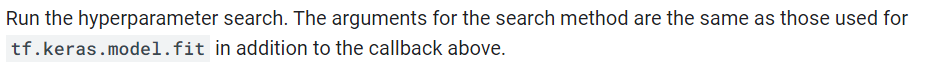

In [365]:
tuner.search(X_train, y_train, 
             epochs=200, 
             validation_data=(X_val, y_val), 
             callbacks=[stop_early,tb])

INFO:tensorflow:Oracle triggered exit


In [366]:
tuner.results_summary()

Results summary
Results in Exhaustive_Opt_norm\Test1_minmax
Showing 10 best trials
Trial summary
Hyperparameters:
units: 6
activation: relu
weight_init: lecun_normal
num_layers: 3
dropout_rate: 0.0
optimizer: RMSprop
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0008339767227880657
Trial summary
Hyperparameters:
units: 6
activation: tanh
weight_init: lecun_normal
num_layers: 2
dropout_rate: 0.1
optimizer: RMSprop
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.0009949041996151209
Trial summary
Hyperparameters:
units: 6
activation: tanh
weight_init: lecun_normal
num_layers: 2
dropout_rate: 0.1
optimizer: RMSprop
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0036
Score: 0.0012171032140031457
Trial summary
Hyperparameters:
units: 9
activation: tanh
weight_init: random_normal
num_layers: 1
dropout_rate: 0.1
optimizer: Adam
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 3
tun

In [367]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [368]:
%tensorboard --logdir Exhaustive_Opt_MinMax/Test1

Reusing TensorBoard on port 6006 (pid 12340), started 4:08:32 ago. (Use '!kill 12340' to kill it.)

## d.  get the optimal hyperparameters

In [369]:

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal activation function is {best_hps.get('activation')}, the optimal weight initialization is {best_hps.get('weight_init')} and the optimal optimizer is {best_hps.get('optimizer')}.
""")




The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 6, the optimal activation function is relu, the optimal weight initialization is lecun_normal and the optimal optimizer is RMSprop.



## e. Train the model using the best model

In [370]:
model = tuner.hypermodel.build(best_hps)


In [371]:
### model training 

mlp_amt_1 = model.fit(X_train, y_train, epochs=300, validation_data = (X_val, y_val), shuffle = 0)


Epoch 1/300
64/64 [==============================] - 3s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 2/300
64/64 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 3/300
64/64 [==============================] - 0s 5ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 4/300
64/64 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 5/300
64/64 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 6/300
64/64 [==============================] - 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 7/300
64/64 [==============

Epoch 50/300
64/64 [==============================] - 1s 8ms/step - loss: 5.3391e-04 - mean_squared_error: 5.3391e-04 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 51/300
64/64 [==============================] - 0s 8ms/step - loss: 5.2755e-04 - mean_squared_error: 5.2755e-04 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 52/300
64/64 [==============================] - 0s 6ms/step - loss: 5.2231e-04 - mean_squared_error: 5.2231e-04 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 53/300
64/64 [==============================] - 0s 6ms/step - loss: 5.1767e-04 - mean_squared_error: 5.1767e-04 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 54/300
64/64 [==============================] - 0s 6ms/step - loss: 5.1340e-04 - mean_squared_error: 5.1340e-04 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 55/300
64/64 [==============================] - 0s 6ms/step - loss: 5.0895e-04 - mean_squared_error: 5.0895e-04 - val_loss: 0.0236 - val_mean_sq

Epoch 146/300
64/64 [==============================] - 0s 5ms/step - loss: 4.4862e-04 - mean_squared_error: 4.4862e-04 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 147/300
64/64 [==============================] - 0s 4ms/step - loss: 4.4816e-04 - mean_squared_error: 4.4816e-04 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 148/300
64/64 [==============================] - 0s 4ms/step - loss: 4.4855e-04 - mean_squared_error: 4.4855e-04 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 149/300
64/64 [==============================] - 0s 4ms/step - loss: 4.4781e-04 - mean_squared_error: 4.4781e-04 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 150/300
64/64 [==============================] - 0s 4ms/step - loss: 4.4768e-04 - mean_squared_error: 4.4768e-04 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 151/300
64/64 [==============================] - 0s 4ms/step - loss: 4.4660e-04 - mean_squared_error: 4.4660e-04 - val_loss: 0.0347 - val_m

Epoch 194/300
64/64 [==============================] - 0s 4ms/step - loss: 4.3142e-04 - mean_squared_error: 4.3142e-04 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 195/300
64/64 [==============================] - 0s 4ms/step - loss: 4.3322e-04 - mean_squared_error: 4.3322e-04 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 196/300
64/64 [==============================] - 0s 4ms/step - loss: 4.3133e-04 - mean_squared_error: 4.3133e-04 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 197/300
64/64 [==============================] - 0s 4ms/step - loss: 4.3290e-04 - mean_squared_error: 4.3290e-04 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 198/300
64/64 [==============================] - 0s 4ms/step - loss: 4.3101e-04 - mean_squared_error: 4.3101e-04 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 199/300
64/64 [==============================] - 0s 4ms/step - loss: 4.3043e-04 - mean_squared_error: 4.3043e-04 - val_loss: 0.0311 - val_m

Epoch 242/300
64/64 [==============================] - 0s 4ms/step - loss: 4.1470e-04 - mean_squared_error: 4.1470e-04 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 243/300
64/64 [==============================] - 0s 5ms/step - loss: 4.1424e-04 - mean_squared_error: 4.1424e-04 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 244/300
64/64 [==============================] - 0s 5ms/step - loss: 4.1341e-04 - mean_squared_error: 4.1341e-04 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 245/300
64/64 [==============================] - 0s 5ms/step - loss: 4.1285e-04 - mean_squared_error: 4.1285e-04 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 246/300
64/64 [==============================] - 0s 5ms/step - loss: 4.1234e-04 - mean_squared_error: 4.1234e-04 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 247/300
64/64 [==============================] - 0s 6ms/step - loss: 4.1172e-04 - mean_squared_error: 4.1172e-04 - val_loss: 0.0303 - val_m

Epoch 290/300
64/64 [==============================] - 0s 5ms/step - loss: 4.0456e-04 - mean_squared_error: 4.0456e-04 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 291/300
64/64 [==============================] - 0s 5ms/step - loss: 4.0382e-04 - mean_squared_error: 4.0382e-04 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 292/300
64/64 [==============================] - 0s 7ms/step - loss: 4.0429e-04 - mean_squared_error: 4.0429e-04 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 293/300
64/64 [==============================] - 0s 5ms/step - loss: 4.0466e-04 - mean_squared_error: 4.0466e-04 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 294/300
64/64 [==============================] - 0s 6ms/step - loss: 4.0385e-04 - mean_squared_error: 4.0385e-04 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 295/300
64/64 [==============================] - 0s 6ms/step - loss: 4.0439e-04 - mean_squared_error: 4.0439e-04 - val_loss: 0.0306 - val_m

In [372]:
model.summary()   #### this shows us that the number of layers are 3 in this MLP model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 30)                0         
                                                                 
 dense_13 (Dense)            (None, 6)                 186       
                                                                 
 dropout_13 (Dropout)        (None, 6)                 0         
                                                                 
 dense_14 (Dense)            (None, 6)                 42        
                                                                 
 dropout_14 (Dropout)        (None, 6)                 0         
                                                                 
 dense_15 (Dense)            (None, 6)                 42        
                                                                 
 dropout_15 (Dropout)        (None, 6)                

In [373]:
#### find the best epoch by looking in to the validation loss

val_acc_per_epoch = mlp_amt_1.history['val_loss']   

#### 'val_loss' should align with the objective function used when applying 'tuner.search' (both should be loss or both accuracy)

best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 9


In [374]:
### Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model

hypermodel.fit(X_train, y_train, epochs= best_epoch, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 

# hypermodel.fit(X_train, y_train, epochs= 250, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 


Epoch 1/9
64/64 [==============================] - 2s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 2/9
64/64 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 3/9
64/64 [==============================] - 0s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 4/9
64/64 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 5/9
64/64 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 6/9
64/64 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 7/9
64/64 [=============================

## f. Test best model

In [375]:

eval_result = hypermodel.evaluate(X_test, y_test)

print("[test loss, test accuracy]:", eval_result)

14/14 [==============================] - 0s 5ms/step - loss: 0.0064 - mean_squared_error: 0.0064
[test loss, test accuracy]: [0.006382390856742859, 0.006382390856742859]


In [376]:
#Y_pred = hypermodel.predict(X_test)   ### results from the hypermodel are giving fluctuating results
Y_pred = hypermodel.predict(X_test)   #### this is giving betetr result(more stable)

14/14 [==============================] - 0s 2ms/step


In [377]:
Y_pred

array([[0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00547551],
       [0.03308362],
       [0.05382814],
       [0.06640915],
       [0.0706155 ],
       [0.07705882],
       [0.08245366],
       [0.08972409],
       [0.0921995 ],
       [0.08846332],
       [0.07725126],
       [0.06441002],
       [0.0913926 ],
       [0.09885333],
       [0.14464885],
       [0.16281208],
       [0.18220422],
       [0.201595  ],
       [0.21975818],
       [0.21155263],
       [0.20900407],
       [0.21421033],
       [0.19783224],
       [0.18147527],
       [0.15479138],
       [0.12619899],
       [0.10250691],
       [0.09273856],
       [0.05916344],
       [0.0628791 ],
       [0.0674902 ],
       [0.05905709],
       [0.07619145],
       [0.08267029],
       [0.09273006],
       [0.11270519],
       [0.1359055 ],
       [0.133

In [378]:
y_test

array([[6.06575276e-04],
       [9.09862914e-04],
       [7.27890331e-04],
       [5.45917748e-04],
       [5.45917748e-04],
       [4.24602693e-04],
       [3.63945166e-04],
       [1.81972583e-04],
       [6.06575276e-05],
       [0.00000000e+00],
       [6.06575276e-05],
       [2.12301347e-03],
       [2.12301347e-03],
       [5.15588985e-03],
       [3.82142424e-03],
       [3.03287638e-03],
       [2.97221885e-03],
       [3.51813660e-03],
       [2.51122164e-02],
       [1.85005459e-02],
       [1.01298071e-02],
       [1.35872862e-02],
       [2.76598326e-02],
       [8.81353876e-02],
       [8.36467306e-02],
       [1.53948805e-01],
       [8.66189494e-02],
       [8.77714424e-02],
       [8.42533058e-02],
       [3.02074487e-02],
       [2.65679971e-02],
       [1.39815601e-01],
       [8.09777993e-02],
       [2.36564358e-02],
       [1.35872862e-02],
       [1.45578066e-02],
       [2.79631202e-02],
       [1.75906830e-02],
       [1.17675604e-02],
       [1.39512313e-02],


In [379]:
y_test.shape

(432, 1)

In [380]:
print(y_test[:,:-1].shape)   
print(y_test[:,1:2].shape)

(432, 0)
(432, 0)


In [381]:
y_test[:,-1:]    ##### all rows and all columns including -1(which is the last column)

array([[6.06575276e-04],
       [9.09862914e-04],
       [7.27890331e-04],
       [5.45917748e-04],
       [5.45917748e-04],
       [4.24602693e-04],
       [3.63945166e-04],
       [1.81972583e-04],
       [6.06575276e-05],
       [0.00000000e+00],
       [6.06575276e-05],
       [2.12301347e-03],
       [2.12301347e-03],
       [5.15588985e-03],
       [3.82142424e-03],
       [3.03287638e-03],
       [2.97221885e-03],
       [3.51813660e-03],
       [2.51122164e-02],
       [1.85005459e-02],
       [1.01298071e-02],
       [1.35872862e-02],
       [2.76598326e-02],
       [8.81353876e-02],
       [8.36467306e-02],
       [1.53948805e-01],
       [8.66189494e-02],
       [8.77714424e-02],
       [8.42533058e-02],
       [3.02074487e-02],
       [2.65679971e-02],
       [1.39815601e-01],
       [8.09777993e-02],
       [2.36564358e-02],
       [1.35872862e-02],
       [1.45578066e-02],
       [2.79631202e-02],
       [1.75906830e-02],
       [1.17675604e-02],
       [1.39512313e-02],


## Evaluation metics

In [382]:
###nse

import hydroeval as he
nse = he.evaluator(he.nse, Y_pred, y_test  )
print(nse)

[0.52221691]


In [383]:
##rmse
rmse = he.evaluator(he.rmse, Y_pred, y_test )
print(rmse)

[0.07988987]


In [384]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg = np.log1p(Y_pred)

#### log of test values
y_test_lg = np.log1p(y_test)


In [385]:
##calculate mse
mse = mean_squared_error(y_pred_lg, y_test_lg)
rmse_lg = np.sqrt(mse)   
print(rmse_lg)

0.06225083773998482


## g. plot

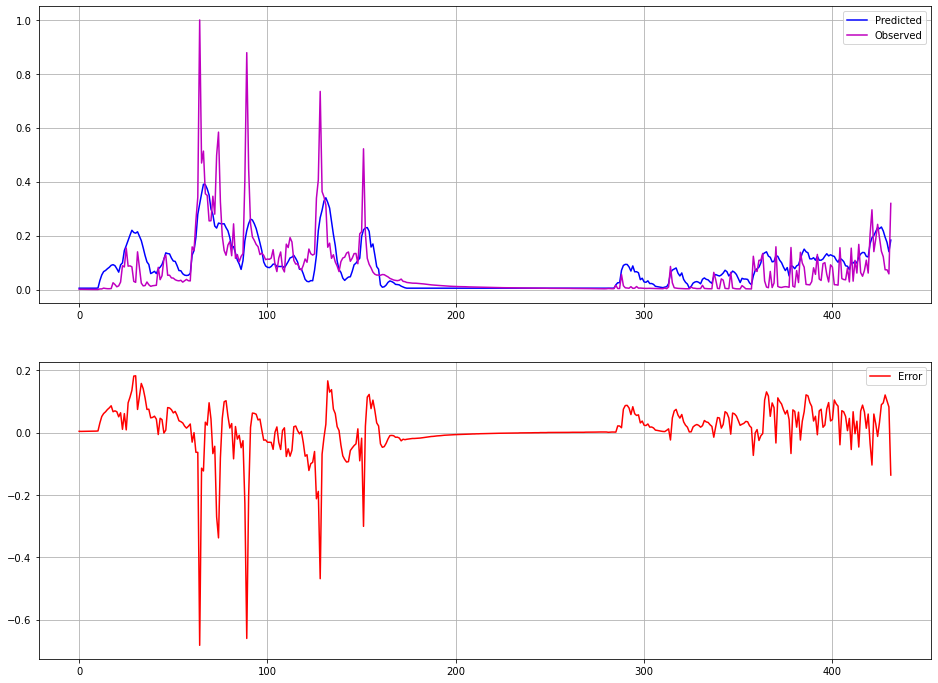

In [386]:
import matplotlib.pyplot as plt
# plt.plot(Q_pred)
# plt.plot(y_test)

plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred[:,-1],'b', label = "Predicted")

plt.plot(y_test[:,-1], 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred[:,-1] - y_test[:,-1],'r', label = "Error")

plt.legend()

plt.grid()

##  save_model

## h. Denormalize the data

In [387]:
#### Original data
df_train_norm

# df_val_f

# df_test_f

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.002408,0.068735,0.009910,0.022464,0.004410,0.077237,0.058489
1,0.000000,0.002408,0.068735,0.009910,0.022464,0.004410,0.035205
2,0.070016,0.000000,0.002408,0.068735,0.009910,0.022464,0.029035
3,0.101199,0.070016,0.000000,0.002408,0.068735,0.009910,0.110629
4,0.016962,0.101199,0.070016,0.000000,0.002408,0.068735,0.075404
...,...,...,...,...,...,...,...
2035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001871
2036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001871
2037,0.000189,0.000000,0.000000,0.000000,0.000000,0.000000,0.001871
2038,0.001588,0.000189,0.000000,0.000000,0.000000,0.000000,0.001771


In [388]:
### normalized data after model training
Y_pred    #### model out put
# y_obser = y_test[:,-1:]      ## observed discharge

array([[0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00491422],
       [0.00547551],
       [0.03308362],
       [0.05382814],
       [0.06640915],
       [0.0706155 ],
       [0.07705882],
       [0.08245366],
       [0.08972409],
       [0.0921995 ],
       [0.08846332],
       [0.07725126],
       [0.06441002],
       [0.0913926 ],
       [0.09885333],
       [0.14464885],
       [0.16281208],
       [0.18220422],
       [0.201595  ],
       [0.21975818],
       [0.21155263],
       [0.20900407],
       [0.21421033],
       [0.19783224],
       [0.18147527],
       [0.15479138],
       [0.12619899],
       [0.10250691],
       [0.09273856],
       [0.05916344],
       [0.0628791 ],
       [0.0674902 ],
       [0.05905709],
       [0.07619145],
       [0.08267029],
       [0.09273006],
       [0.11270519],
       [0.1359055 ],
       [0.133

In [389]:
def denormalize(data, original_data, type='min_max'):   ### default is min-max in this case(there is no reason behind this)

    if type == 'min_max':
        min = np.min(original_data)
        max = np.max(original_data)
        data = data * (max - min) + min
    elif type == 'z_score':
        mean = np.mean(original_data)
        std = np.std(original_data)
        data = data * std + mean
    elif type == 'max':                
        max = np.max(original_data)
        data = data * max
    else:
        raise ValueError("Invalid normalization type. Choose either 'max', 'min_max', or 'z_score'.")
    return data

In [390]:
Y_observ_unnorm = df_test['Qt']

In [391]:
Y_observ_unnorm = Y_observ_unnorm.to_numpy()

###  denormalized predicted discharge

In [392]:
### Standard denormalization (becasue we used standard(z-score) in this experiment)

Y_pred_denorm = denormalize(Y_pred, Y_observ_unnorm, type='min_max')

In [393]:
print(Y_pred_denorm)
print(Y_pred_denorm.shape)

[[ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 19.501583]
 [ 20.426922]
 [ 65.94166 ]
 [100.141075]
 [120.88212 ]
 [127.81671 ]
 [138.43916 ]
 [147.3331  ]
 [159.31912 ]
 [163.40009 ]
 [157.24062 ]
 [138.75641 ]
 [117.58635 ]
 [162.06982 ]
 [174.36958 ]
 [249.86809 ]
 [279.81198 ]
 [311.78186 ]
 [343.74948 ]
 [373.69333 ]
 [360.16565 ]
 [355.9641  ]
 [364.54715 ]
 [337.54623 ]
 [310.5801  ]
 [266.58908 ]
 [219.45164 ]
 [180.39288 ]
 [164.28879 ]
 [108.93685 ]
 [115.062485]
 [122.66434 ]
 [108.76152 ]
 [137.00922 ]
 [147.69023 ]
 [164.27477 ]
 [197.20578 ]
 [235.45381 ]
 [231.07431 ]
 [229.41466 ]
 [203.69505 ]
 [185.5278  ]
 [183.52708 ]
 [157.62506 ]
 [127.28579 ]
 [126.13318 ]
 [107.8469  ]
 [ 99.34615 ]
 [ 97.140076]
 [ 98.84368 ]
 [109.64379 ]
 [221.79381 ]
 [249.85335 ]
 [330.11365 ]
 [471.82263 ]
 [535.4048  ]
 [597.15234 ]
 [655.41675 ]
 [652.35925 ]
 [626.7545  ]
 [589.0354  ]
 [503.84546 ]
 [471.

### denormalized Observed discharge

In [394]:
len(y_test)

432

In [395]:
Y_obser_denorm = denormalize(y_test, Y_observ_unnorm, type='min_max')

In [396]:
Y_obser_denorm 

array([[  12.4],
       [  12.9],
       [  12.6],
       [  12.3],
       [  12.3],
       [  12.1],
       [  12. ],
       [  11.7],
       [  11.5],
       [  11.4],
       [  11.5],
       [  14.9],
       [  14.9],
       [  19.9],
       [  17.7],
       [  16.4],
       [  16.3],
       [  17.2],
       [  52.8],
       [  41.9],
       [  28.1],
       [  33.8],
       [  57. ],
       [ 156.7],
       [ 149.3],
       [ 265.2],
       [ 154.2],
       [ 156.1],
       [ 150.3],
       [  61.2],
       [  55.2],
       [ 241.9],
       [ 144.9],
       [  50.4],
       [  33.8],
       [  35.4],
       [  57.5],
       [  40.4],
       [  30.8],
       [  34.4],
       [  35.6],
       [  37.4],
       [ 147. ],
       [  71.6],
       [  95.5],
       [ 199.4],
       [ 222. ],
       [  98.5],
       [  98.9],
       [  82.4],
       [  81.2],
       [  71.2],
       [  66.4],
       [  64.4],
       [  68. ],
       [  56.5],
       [  64.7],
       [  73.2],
       [  65.2

# Plot the denomalized data

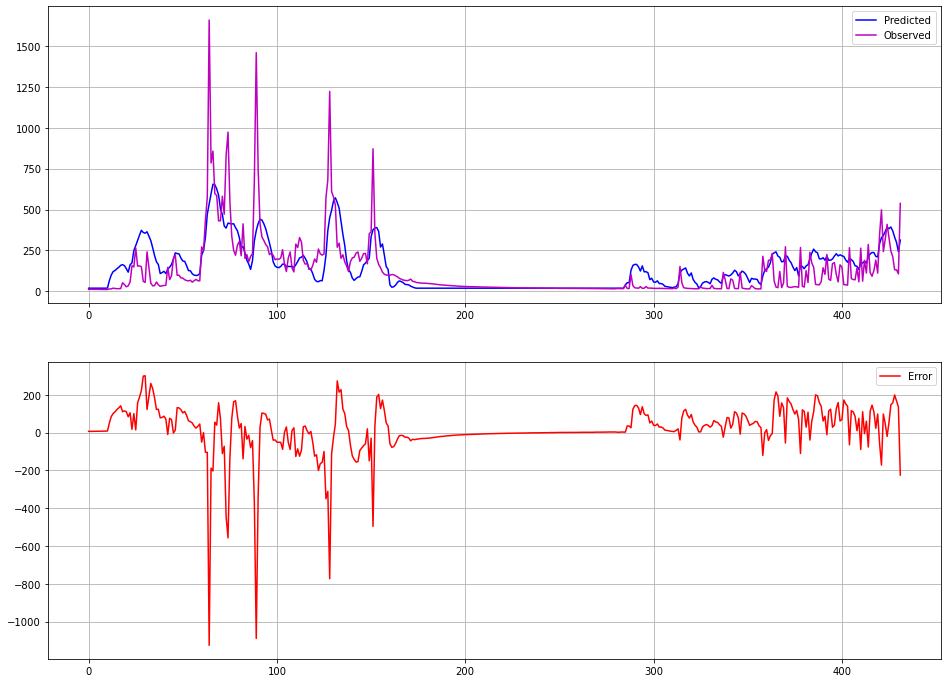

In [397]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_denorm,'b', label = "Predicted")

plt.plot(Y_obser_denorm , 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_denorm - Y_obser_denorm ,'r', label = "Error")

plt.legend()

plt.grid()

### NSE after denormalization

In [398]:
nse_d = he.evaluator(he.nse, Y_pred_denorm , Y_obser_denorm  )
print(nse_d)

[0.52221692]


### RMSE after denormalization (in m3/sec)

In [399]:
#### rmse in m3/sec
rmse_d = he.evaluator(he.rmse, Y_pred_denorm, Y_obser_denorm)
print(rmse_d)    ### 

[131.70643673]
